In [114]:
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import sklearn as sk

%matplotlib inline
%config InlineBackend.figure_formats = {'png','retina'}

import matplotlib as mpl
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()

pd.set_option('display.max_rows', 30000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


import pandas_profiling as pdp

---

# Shelter Animal Outcomes
- 유기 동물 보호소에서 동물들이 어떤 결과를 가져올 것인가를 예측
- 데이터 크기는 작지만 주제가 흥미롭고, 외부 데이터를 사용해보거나, breed, color의 텍스트 데이터를 어떻게 처리할 것인가에 대한 고민이 주요포인트
- https://www.kaggle.com/c/shelter-animal-outcomes

In [76]:
df_train_animal = pd.read_csv("./shelter/train.csv")
print(df_train_animal.shape)
df_train_animal.tail()

(26729, 10)


AnimalID  Name             DateTime OutcomeType OutcomeSubtype AnimalType SexuponOutcome AgeuponOutcome                    Breed              Color
26724  A702446   NaN  2015-05-14 11:56:00    Transfer        Partner        Cat    Intact Male        1 month   Domestic Shorthair Mix  Brown Tabby/White
26725  A718934   NaN  2016-01-20 18:59:00    Transfer           SCRP        Cat  Spayed Female       3 months   Domestic Shorthair Mix        Brown Tabby
26726  A698128  Zeus  2015-03-09 13:33:00    Adoption            NaN        Dog  Neutered Male        4 years  Old English Bulldog Mix          White/Tan
26727  A677478   NaN  2014-04-27 12:22:00    Transfer        Partner        Cat    Intact Male        4 weeks   Domestic Shorthair Mix              Black
26728  A706629   NaN  2015-07-02 09:00:00    Transfer           SCRP        Cat    Intact Male         1 year   Domestic Shorthair Mix  Brown Tabby/White

In [77]:
# pdp.ProfileReport(df_train_animal)
df_train_animal.describe()

AnimalID   Name             DateTime OutcomeType OutcomeSubtype AnimalType SexuponOutcome AgeuponOutcome                   Breed        Color
count     26729  19038                26729       26729          13117      26729          26728          26711                   26729        26729
unique    26729   6374                22918           5             16          2              5             44                    1380          366
top     A664666    Max  2015-08-11 00:00:00    Adoption        Partner        Dog  Neutered Male         1 year  Domestic Shorthair Mix  Black/White
freq          1    136                   19       10769           7816      15595           9779           3969                    8810         2824

In [78]:
# 사용되는 데이터프레임 명칭 변경
df_shelter = df_train_animal.copy()
df_shelter["Name_exsist"] = df_shelter["Name"].isnull().astype(int)


In [79]:
# df_shelter.tail()

In [118]:
# NaN값 처리

df_shelter["OutcomeSubtype"] = df_shelter["OutcomeSubtype"].fillna("NoStatus")
df_shelter["SexuponOutcome"] = df_shelter["SexuponOutcome"].fillna("Unknown")
df_shelter["AgeuponOutcome"] = df_shelter["AgeuponOutcome"].fillna("Unknown")
# df_shelter["SexuponOutcome"].unique()
# df_shelter["OutcomeType"].unique()
df_shelter["AgeuponOutcome"].unique()

array(['1 year', '2 years', '3 weeks', '1 month', '5 months', '4 years',
       '3 months', '2 weeks', '2 months', '10 months', '6 months',
       '5 years', '7 years', '3 years', '4 months', '12 years', '9 years',
       '6 years', '1 weeks', '11 years', '4 weeks', '7 months', '8 years',
       '11 months', '4 days', '9 months', '8 months', '15 years',
       '10 years', '1 week', '0 years', '14 years', '3 days', '6 days',
       '5 days', '5 weeks', '2 days', '16 years', '1 day', '13 years',
       'Unknown', '17 years', '18 years', '19 years', '20 years'], dtype=object)

In [112]:
df_shelter[(df_shelter["OutcomeSubtype"]=="Suffering")&(df_shelter["OutcomeType"]=="Euthanasia")].reset_index(drop=True)
# 1. 고통받는 동물은 모두 안락사되었다

AnimalID          Name             DateTime OutcomeType OutcomeSubtype AnimalType SexuponOutcome AgeuponOutcome                                      Breed                Color  Name_exsist  OutcomeType_c  OutcomeSubtype_c  AnimalType_c  SexuponOutcome_c  Breed_c  Color_c
0     A656520         Emily  2013-10-13 12:44:00  Euthanasia      Suffering        Cat  Spayed Female         1 year                     Domestic Shorthair Mix          Cream Tabby            0              2                16             0                 3      640      167
1     A718535           NaN  2016-01-01 13:57:00  Euthanasia      Suffering        Cat  Spayed Female        3 years                     Domestic Shorthair Mix               Calico            1              2                16             0                 3      640      139
2     A668626           NaN  2013-12-06 14:55:00  Euthanasia      Suffering        Dog    Intact Male        3 years                     Labrador Retriever Mix               Yellow            1              2                16             1                 1      847      358
3     A678506  Prec Punkin'  2014-05-09 18:07:00  Euthanasia      Suffering        Dog  Spayed Female       11 years                      Yorkshire Terrier Mix          Brown/Black            0              2                16             1                 3     1365      114
4     A675021           NaN  2014-03-21 17:09:00  Euthanasia      Suffering        Cat  Intact Female         1 year                     Domestic Shorthair Mix               Calico            1              2                16             0                 0      640      139
5     A712376           NaN  2015-09-22 12:10:00  Euthanasia      Suffering        Cat        Unknown        2 weeks                     Domestic Shorthair Mix           Blue Tabby            1              2                16             0                 4      640       63
6     A691838       Avaddon  2015-02-09 17:17:00  Euthanasia      Suffering        Dog  Neutered Male       12 years                               Pit Bull Mix        Brown Brindle            0              2                16             1                 2     1066       89
7     A695971           NaN  2015-01-26 16:23:00  Euthanasia      Suffering        Cat    Intact Male        6 years                     Domestic Shorthair Mix         Orange Tabby            1              2                16             0                 1      640      216
8     A691968           NaN  2014-11-14 11:57:00  Euthanasia      Suffering        Cat  Intact Female        7 years                     Domestic Shorthair Mix               Tortie            1              2                16             0                 0      640      296
9     A702207           NaN  2015-05-10 17:16:00  Euthanasia      Suffering        Cat  Neutered Male       12 years                      Domestic Longhair Mix   Orange Tabby/White            1              2                16             0                 2      632      220
10    A702356           NaN  2015-05-24 17:25:00  Euthanasia      Suffering        Cat    Intact Male        1 month                     Domestic Shorthair Mix     White/Blue Tabby            1              2                16             0                 1      640      327
11    A689138           NaN  2014-09-29 18:28:00  Euthanasia      Suffering        Cat  Intact Female        4 weeks                                Siamese Mix           Blue Point            1              2                16             0                 0     1251       59
12    A599155       Machete  2015-03-28 19:25:00  Euthanasia      Suffering        Dog  Neutered Male        4 years                    Chihuahua Shorthair Mix          White/Brown            0              2                16             1                 2      450      329
13    A710227     Sebastian  2015-08-24 18:23:00  Euthanasia      Suffering        Cat  Neutered Male       12 years           

In [109]:
#라벨인코딩

from sklearn.preprocessing import LabelEncoder

OT = LabelEncoder()
y = df_shelter["OutcomeType"]
OT.fit(y)
df_shelter["OutcomeType_c"] = OT.transform(y)
animal = LabelEncoder()

OS = LabelEncoder()
y = df_shelter["OutcomeSubtype"]
OS.fit(y)
df_shelter["OutcomeSubtype_c"] = OS.transform(y)

AT = LabelEncoder()
y = df_shelter["AnimalType"]
AT.fit(y)
df_shelter["AnimalType_c"] = AT.transform(y)

SO = LabelEncoder()
y = df_shelter["SexuponOutcome"]
SO.fit(y)
df_shelter["SexuponOutcome_c"] = SO.transform(y)

Br = LabelEncoder()
y = df_shelter["Breed"]
Br.fit(y)
df_shelter["Breed_c"] = Br.transform(y)

Col = LabelEncoder()
y = df_shelter["Color"]
Col.fit(y)
df_shelter["Color_c"] = Col.transform(y)


# y2.tail()

In [107]:
df_shelter.tail()

AnimalID  Name             DateTime OutcomeType OutcomeSubtype AnimalType SexuponOutcome AgeuponOutcome                    Breed              Color  Name_exsist  OutcomeType_c  OutcomeSubtype_c  AnimalType_c  SexuponOutcome_c  Breed_c  Color_c
26724  A702446   NaN  2015-05-14 11:56:00    Transfer        Partner        Cat    Intact Male        1 month   Domestic Shorthair Mix  Brown Tabby/White            1              4                13             0                 1      640      111
26725  A718934   NaN  2016-01-20 18:59:00    Transfer           SCRP        Cat  Spayed Female       3 months   Domestic Shorthair Mix        Brown Tabby            1              4                15             0                 3      640      104
26726  A698128  Zeus  2015-03-09 13:33:00    Adoption       NoStatus        Dog  Neutered Male        4 years  Old English Bulldog Mix          White/Tan            0              0                11             1                 2     1022      353
26727  A677478   NaN  2014-04-27 12:22:00    Transfer        Partner        Cat    Intact Male        4 weeks   Domestic Shorthair Mix              Black            1              4                13             0                 1      640        5
26728  A706629   NaN  2015-07-02 09:00:00    Transfer           SCRP        Cat    Intact Male         1 year   Domestic Shorthair Mix  Brown Tabby/White            1              4                15             0                 1      640      111

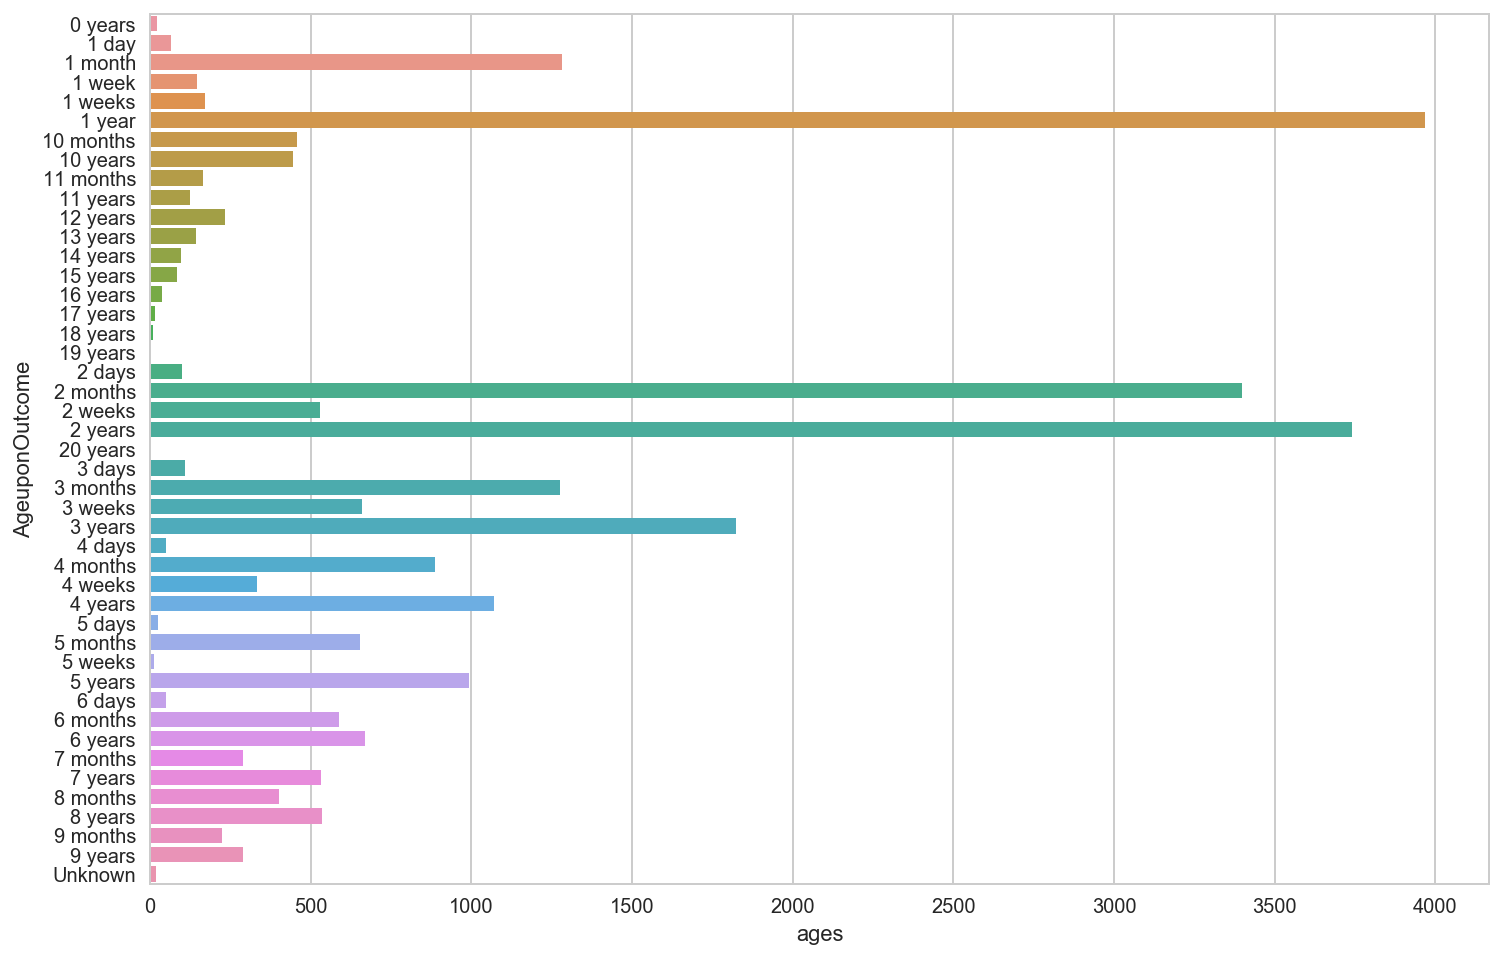

In [138]:
sorted_df = df_shelter.groupby("AgeuponOutcome").size().reset_index(name="count")
X = sorted_df["count"]
Y = sorted_df["AgeuponOutcome"]
# plt.barh(X,Y)
fig = plt.figure(figsize=(12,8))
ax = sns.barplot(data = sorted_df, x="count", y="AgeuponOutcome")
# sns.countplot('AgeuponOutcome',data=df_shelter)
ax.set_xlabel('ages')

In [142]:
pdp.ProfileReport(df_shelter.iloc[:,10:])

In [115]:
df_shelter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26729 entries, 0 to 26728
Data columns (total 17 columns):
AnimalID            26729 non-null object
Name                19038 non-null object
DateTime            26729 non-null object
OutcomeType         26729 non-null object
OutcomeSubtype      26729 non-null object
AnimalType          26729 non-null object
SexuponOutcome      26729 non-null object
AgeuponOutcome      26711 non-null object
Breed               26729 non-null object
Color               26729 non-null object
Name_exsist         26729 non-null int32
OutcomeType_c       26729 non-null int64
OutcomeSubtype_c    26729 non-null int64
AnimalType_c        26729 non-null int64
SexuponOutcome_c    26729 non-null int64
Breed_c             26729 non-null int64
Color_c             26729 non-null int64
dtypes: int32(1), int64(6), object(10)
memory usage: 3.4+ MB


In [24]:
df_samplesub_animal = pd.read_csv("./shelter/sample_submission.csv")
print(df_samplesub_animal.shape)
df_samplesub_animal.tail()

(11456, 6)


ID  Adoption  Died  Euthanasia  Return_to_owner  Transfer
11451  11452         1     0           0                0         0
11452  11453         1     0           0                0         0
11453  11454         1     0           0                0         0
11454  11455         1     0           0                0         0
11455  11456         1     0           0                0         0

# Walmart Recruiting: Trip Type Classification
- Here's the decryption key: Work4WalmarT
- 마트에 오는 customer의 product code를 가지고 고객의 triptype을 예측한다
- https://www.kaggle.com/c/walmart-recruiting-trip-type-classification

In [20]:
df_train_walmart = pd.read_csv("./walmart/train.csv")
print(df_train_walmart.shape)
df_train_walmart.tail()

(647054, 7)


TripType  VisitNumber Weekday           Upc  ScanCount DepartmentDescription  FinelineNumber
647049        39       191346  Sunday  3.239000e+10          1          PHARMACY OTC          1118.0
647050        39       191346  Sunday  7.874205e+09          1          FROZEN FOODS          1752.0
647051        39       191346  Sunday  4.072000e+03          1               PRODUCE          4170.0
647052         8       191347  Sunday  4.190008e+09          1                 DAIRY          1512.0
647053         8       191347  Sunday  3.800060e+09          1     GROCERY DRY GOODS          3600.0

- 각 TripType에 대한 proba를 제출

In [21]:
df_samplesub_walmart = pd.read_csv("./walmart/sample_submission.csv")
print(df_samplesub_walmart.shape)
df_samplesub_walmart.tail()

(95674, 39)


VisitNumber  TripType_3  TripType_4  TripType_5  TripType_6  TripType_7  TripType_8  TripType_9  TripType_12  TripType_14  TripType_15  TripType_18  TripType_19  TripType_20  TripType_21  TripType_22  TripType_23  TripType_24  TripType_25  TripType_26  TripType_27  TripType_28  TripType_29  TripType_30  TripType_31  TripType_32  TripType_33  TripType_34  TripType_35  TripType_36  TripType_37  TripType_38  TripType_39  TripType_40  TripType_41  TripType_42  TripType_43  TripType_44  TripType_999
95669       191338           0           0           0           0           0           0           0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0             0
95670       191339           0           0           0           0           0           0           0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0             0
95671       191340           0           0           0           0           0           0           0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0             0
95672       191341           0           0           0           0           0           0           0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0             0
95673       191348           0           0           0           0           0           0           0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0             0

In [26]:
pdp.describe(df_train_walmart)

{'correlations': {'pearson':                 TripType  VisitNumber       Upc  ScanCount  FinelineNumber
  TripType        1.000000     0.000805  0.047150  -0.286024       -0.028604
  VisitNumber     0.000805     1.000000 -0.001812  -0.005500        0.008771
  Upc             0.047150    -0.001812  1.000000  -0.038090       -0.062611
  ScanCount      -0.286024    -0.005500 -0.038090   1.000000        0.004078
  FinelineNumber -0.028604     0.008771 -0.062611   0.004078        1.000000,
  'spearman':                 TripType  VisitNumber       Upc  ScanCount  FinelineNumber
  TripType        1.000000    -0.001595 -0.043410  -0.049149        0.026259
  VisitNumber    -0.001595     1.000000 -0.011269  -0.005303        0.009715
  Upc            -0.043410    -0.011269  1.000000  -0.026828       -0.021534
  ScanCount      -0.049149    -0.005303 -0.026828   1.000000        0.007189
  FinelineNumber  0.026259     0.009715 -0.021534   0.007189        1.000000},
 'freq': {'DepartmentDescription':

# Forest Cover Type Prediction
- Roosevelt National Forest of northern Colorado의 30m X 30m의 숲 타입을 분류하는 문제
- https://www.kaggle.com/c/forest-cover-type-prediction/data

In [22]:
df_train_forest = pd.read_csv("./forest/train.csv")
print(df_train_forest.shape)
df_train_forest.tail()

(15120, 56)


Id  Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  Hillshade_9am  Hillshade_Noon  Hillshade_3pm  Horizontal_Distance_To_Fire_Points  Wilderness_Area1  Wilderness_Area2  Wilderness_Area3  Wilderness_Area4  Soil_Type1  Soil_Type2  Soil_Type3  Soil_Type4  Soil_Type5  Soil_Type6  Soil_Type7  Soil_Type8  Soil_Type9  Soil_Type10  Soil_Type11  Soil_Type12  Soil_Type13  Soil_Type14  Soil_Type15  Soil_Type16  Soil_Type17  Soil_Type18  Soil_Type19  Soil_Type20  Soil_Type21  Soil_Type22  Soil_Type23  Soil_Type24  Soil_Type25  Soil_Type26  Soil_Type27  Soil_Type28  Soil_Type29  Soil_Type30  Soil_Type31  Soil_Type32  Soil_Type33  Soil_Type34  Soil_Type35  Soil_Type36  Soil_Type37  Soil_Type38  Soil_Type39  Soil_Type40  Cover_Type
15115  15116       2607     243     23                               258                               7                              660            170             251            214                                1282                 0                 0                 1                 0           0           0           0           1           0           0           0           0           0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0           3
15116  15117       2603     121     19                               633                             195                              618            249             221             91                                1325                 0                 0                 1                 0           0           0           0           1           0           0           0           0           0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0           3
15117  15118       2492     134     25                               365                             117                              335            250             220             83                                1187                 0                 0                 1                 0           0           0           0           1           0           0           0           0           0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0           3
15118  15119       2487     167     28                               218                             101                              242            229             237            119                                 932                 0                 0                 1                 0           0           0           0           1           0           0           0           0           0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0            0

In [23]:
df_train_forest["Cover_Type"].unique()

array([5, 2, 1, 7, 3, 6, 4])

In [23]:
pdp.ProfileReport(df_train_forest)